# Entrenamiento de Tenis para elegir pista 

### Conjunto de datos

#### Descripción del conjunto de datos y tarea a realizar
Para este proyecto vamos a utilizar el conjunto de datos de los partidos realizados en la ATP desde el año 2010 hasta el 2021, con esto realizaremos una serie de modelos de clasificación con los que predecir en base a las caracteristicas de un jugador vencedor y de otro perdedor, cual sería el tipo de superficie más idonea para que el resultado planteado ocurriera, para esto tambien incluiremos su ranking en la ATP.

In [93]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Cargamos el conjunto de datos con todos los partidos de la ATP desde 2010 hasta 2021
all_atp_games = spark.read.csv("file:///home/alumno/Desktop/pyspark_mllib_regresion_project/datasets/all_atp_games.csv", header=True, inferSchema=True, sep=",")

### Ahora realizamos una limpieza de las columnas que no vamos a utilizar
# primero eliminamos las columnas que nos dan información sobre el torneo o datos externos al juego en si
columns_to_drop = ['tourney_name', 'tourney_id', 'draw_size', 'match_num', 'winner_id', 'loser_id', 'winner_name', 'loser_name',
                  'winner_seed', 'winner_entry', 'winner_ioc', 'loser_seed', 'loser_entry', 'loser_ioc',
                  'best_of', 'round']
all_atp_games = all_atp_games.drop(*columns_to_drop)

# vamos a eliminar todos los registros los cuales no cuentes con la altura del vencedor o perdedor
all_atp_games = all_atp_games.dropna('any', subset=['winner_ht', 'loser_ht'])
# tambien los datos sin el terreno definido los eliminaremos
all_atp_games = all_atp_games.dropna('all', subset=['surface'])

# creamos una nueva columna con el año que ocurrió el partido
all_atp_games = all_atp_games.withColumn("year", expr('LEFT(tourney_date,4)'))


all_atp_games.show(4)

+-------+-------------+------------+-----------+---------+-------------+----------+--------+-------------+-----------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+----+
|surface|tourney_level|tourney_date|winner_hand|winner_ht|   winner_age|loser_hand|loser_ht|    loser_age|      score|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|year|
+-------+-------------+------------+-----------+---------+-------------+----------+--------+-------------+-----------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+----------------

#### Operaciones con API de datos estructurados

In [94]:
# Para las variables de respuesta (categorica), calcular estadísticas agregadas de las variables predictoras
# en base a la de respuesta

# Vamos a observar la media, minimo y máximo de edad y altura del ganador y perdedor en cada tipo de superficie
height_by_surface = all_atp_games.groupBy(col('surface')).agg(expr('mean(winner_ht)'),expr('mean(loser_ht)'),
                                         expr('max(winner_ht)'),expr('max(loser_ht)'),
                                         expr('min(winner_ht)'),expr('min(loser_ht)'))

age_by_surface = all_atp_games.groupBy(col('surface')).agg(expr('mean(winner_age)'),expr('mean(loser_age)'),
                                         expr('max(winner_age)'),expr('max(loser_age)'),
                                         expr('min(winner_age)'),expr('min(loser_age)'))

rank_by_surface = all_atp_games.groupBy(col('surface')).agg(expr('mean(winner_rank)'),expr('mean(loser_rank)'),
                                         expr('max(winner_rank)'),expr('max(loser_rank)'),
                                         expr('min(winner_rank)'),expr('min(loser_rank)'))


height_by_surface.show()
age_by_surface.show()
rank_by_surface.show()

+-------+------------------+------------------+--------------+-------------+--------------+-------------+
|surface|   mean(winner_ht)|    mean(loser_ht)|max(winner_ht)|max(loser_ht)|min(winner_ht)|min(loser_ht)|
+-------+------------------+------------------+--------------+-------------+--------------+-------------+
| Carpet|186.46153846153845|184.46153846153845|         203.0|        203.0|         178.0|        173.0|
|   Clay| 185.9159496004917|185.76367547633683|         208.0|        208.0|         163.0|        163.0|
|   Hard|187.10770846800258|186.23392049127344|         208.0|        208.0|         163.0|        163.0|
|  Grass|187.43357783211084| 186.2681336593317|         208.0|        208.0|         163.0|        163.0|
+-------+------------------+------------------+--------------+-------------+--------------+-------------+

+-------+------------------+------------------+---------------+--------------+---------------+--------------+
|surface|  mean(winner_age)|   mean(loser

Se puede observar independientemente del tipo de pista, los ganadores son de media más altos, más jovenes y con una mejor posición en el ranking.
A excepción de los jugadores en Grass (Hierba) donde la media de los jugadores ganadores son mayores, esto es interesante aunque habría que analizar con más profundidad para deducir algo.

In [95]:
# Contamos con demasiados registros, así que vamos a reducir esto, primero vamos a ver cuantos registros tenemos de cada año
print("Datos totales:", all_atp_games.count())
all_atp_games.groupBy("year").count().show()
# contamos con 12 años diferentes, vamos a tratar de hacer un muestreo estratificado para obtener
# un conjunto reducido.
porcentaje_por_clase = 0.125
seed_stratified = 12
fracciones = all_atp_games.select("year").distinct().withColumn("fraccion", lit(porcentaje_por_clase)).rdd.collectAsMap()
all_atp_games_reducido = all_atp_games.stat.sampleBy("year", fracciones, seed_stratified)

# vamos a comprobar la distribución y total de muestras actuales
print("Nuevos datos reducidos:", all_atp_games_reducido.count())
all_atp_games_reducido.groupBy("year").count().show()

Datos totales: 21351
+----+-----+
|year|count|
+----+-----+
|2016| 2010|
|2012| 2771|
|2020|  275|
|2019|  812|
|2017| 1641|
|2014| 2252|
|2013| 2533|
|2018| 1214|
|2011| 2746|
|2021|  123|
|2015| 2200|
|2010| 2774|
+----+-----+

Nuevos datos reducidos: 2616
+----+-----+
|year|count|
+----+-----+
|2016|  234|
|2012|  345|
|2020|   31|
|2019|   94|
|2017|  192|
|2014|  247|
|2013|  326|
|2018|  165|
|2011|  355|
|2021|   18|
|2015|  238|
|2010|  371|
+----+-----+



In [ ]:
# Vamos a proyectar con las variables de winner_age, winner_ht, loser_age, loser_ht y minutes. 
# Ademas de surface (variable a predecir).


#### Analisis variable a variable

In [106]:
# altura
height_resume_winner = all_atp_games.selectExpr('mean(winner_ht) as mean_winner', 'percentile(winner_ht, 0.5) as median_winner',
                                         'percentile(winner_ht, 0.25) as Q1_winner', 'percentile(winner_ht, 0.75) as Q3_winner',
                                        'kurtosis(winner_ht) as kurtosis_winner', 'skewness(winner_ht) as skewness_winner')

height_resume_loser = all_atp_games.selectExpr('mean(loser_ht) as mean_loser', 'percentile(loser_ht, 0.5) as median_loser',
                                         'percentile(loser_ht, 0.25) as Q1_loser', 'percentile(loser_ht, 0.75) as Q3_loser',
                                        'kurtosis(loser_ht) as kurtosis_loser', 'skewness(loser_ht) as skewness_loser')
# edad
age_resume_winner = all_atp_games.selectExpr('mean(winner_age) as mean_winner', 'percentile(winner_age, 0.5) as median_winner',
                                         'percentile(winner_age, 0.25) as Q1_winner', 'percentile(winner_age, 0.75) as Q3_winner',
                                        'kurtosis(winner_age) as kurtosis_winner', 'skewness(winner_age) as skewness_winner')

age_resume_loser = all_atp_games.selectExpr('mean(loser_age) as mean_loser', 'percentile(loser_age, 0.5) as median_loser',
                                         'percentile(loser_age, 0.25) as Q1_loser', 'percentile(loser_age, 0.75) as Q3_loser',
                                        'kurtosis(loser_age) as kurtosis_loser', 'skewness(loser_age) as skewness_loser')

# rank
rank_resume_winner = all_atp_games.selectExpr('mean(winner_rank) as mean_winner', 'percentile(winner_rank, 0.5) as median_winner',
                                         'percentile(winner_rank, 0.25) as Q1_winner', 'percentile(winner_rank, 0.75) as Q3_winner',
                                        'kurtosis(winner_rank) as kurtosis_winner', 'skewness(winner_rank) as skewness_winner')

rank_resume_loser = all_atp_games.selectExpr('mean(loser_rank) as mean_loser', 'percentile(loser_rank, 0.5) as median_loser',
                                         'percentile(loser_rank, 0.25) as Q1_loser', 'percentile(loser_rank, 0.75) as Q3_loser',
                                        'kurtosis(loser_rank) as kurtosis_loser', 'skewness(loser_rank) as skewness_loser')

# minute
minute_resume = all_atp_games.selectExpr('mean(minutes) as mean', 'percentile(minutes, 0.5) as median',
                                         'percentile(minutes, 0.25) as Q1', 'percentile(minutes, 0.75) as Q3',
                                        'kurtosis(minutes) as kurtosis', 'skewness(minutes) as skewness')
minute_resume_by_surface = all_atp_games.groupBy('surface').agg(expr('mean(minutes) as mean'), expr('percentile(minutes, 0.5) as median'),
                                                               expr('percentile(minutes, 0.25) as Q1'),
                                                               expr('percentile(minutes, 0.75) as Q3'),
                                                               expr('kurtosis(minutes) as kurtosis'),
                                                               expr('skewness(minutes) as skewness'),
                                                               expr('count(minutes) as count'))

resumen height
+------------------+-------------+---------+---------+------------------+------------------+
|       mean_winner|median_winner|Q1_winner|Q3_winner|   kurtosis_winner|   skewness_winner|
+------------------+-------------+---------+---------+------------------+------------------+
|186.78150906280737|        185.0|    183.0|    190.0|0.9563028975361609|0.1223403310514726|
+------------------+-------------+---------+---------+------------------+------------------+

+------------------+------------+--------+--------+------------------+-------------------+
|        mean_loser|median_loser|Q1_loser|Q3_loser|    kurtosis_loser|     skewness_loser|
+------------------+------------+--------+--------+------------------+-------------------+
|186.09343824645217|       185.0|   183.0|   190.0|0.9726121123526483|0.20183622878329982|
+------------------+------------+--------+--------+------------------+-------------------+



array([[<AxesSubplot:title={'center':'loser_ht'}>]], dtype=object)

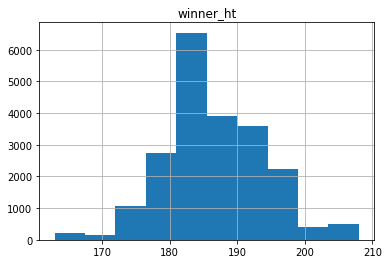

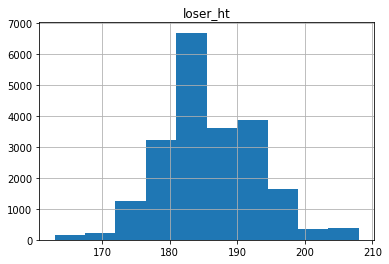

In [107]:
# vamos a transformar el conjunto de datos a un df de pandas para observar el histograma de cada variable
all_atp_games_df = all_atp_games.toPandas()

print("resumen height")
height_resume_winner.show()
all_atp_games_df.hist(column = "winner_ht")
height_resume_loser.show()
all_atp_games_df.hist(column = "loser_ht")

La altura de los jugadores parece seguir una distribución aproximadamente normal observando su histograma, kurtosis y asimetría.

resumen age
+------------------+-------------+-------------+-------------+-------------------+-------------------+
|       mean_winner|median_winner|    Q1_winner|    Q3_winner|    kurtosis_winner|    skewness_winner|
+------------------+-------------+-------------+-------------+-------------------+-------------------+
|27.938521779207857|27.9561943874|25.3333333333|30.3819301848|-0.2381196501196028|0.11212895558018926|
+------------------+-------------+-------------+-------------+-------------------+-------------------+

+------------------+-------------+-------------+-------------+--------------------+-------------------+
|        mean_loser| median_loser|     Q1_loser|     Q3_loser|      kurtosis_loser|     skewness_loser|
+------------------+-------------+-------------+-------------+--------------------+-------------------+
|28.109353871509796|28.1451060917|25.4674880219|30.6529774127|-0.24004369339201181|0.05410906094483568|
+------------------+-------------+-------------+--------

array([[<AxesSubplot:title={'center':'loser_age'}>]], dtype=object)

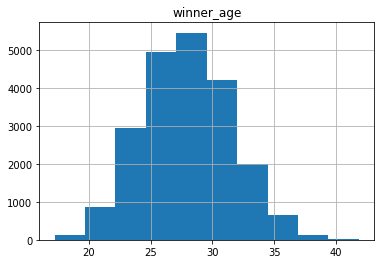

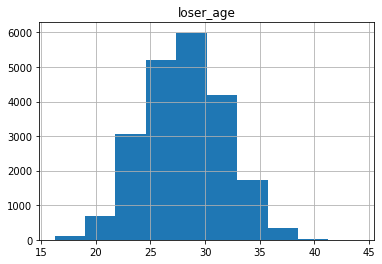

In [108]:
print("resumen age")
age_resume_winner.show()
all_atp_games_df.hist(column = "winner_age")
age_resume_loser.show()
all_atp_games_df.hist(column = "loser_age")

La edad de los jugadores parece seguir una distribución aproximadamente normal observando su histograma, kurtosis y asimetría.

resumen rank
+-----------------+-------------+---------+---------+----------------+-----------------+
|      mean_winner|median_winner|Q1_winner|Q3_winner| kurtosis_winner|  skewness_winner|
+-----------------+-------------+---------+---------+----------------+-----------------+
|50.34343955014058|         35.0|     13.0|     67.0|75.8155865186531|5.780995049043726|
+-----------------+-------------+---------+---------+----------------+-----------------+

+-----------------+------------+--------+--------+-----------------+-----------------+
|       mean_loser|median_loser|Q1_loser|Q3_loser|   kurtosis_loser|   skewness_loser|
+-----------------+------------+--------+--------+-----------------+-----------------+
|76.09496315072994|        57.0|    30.0|    91.0|63.52386458061211|6.025043502357451|
+-----------------+------------+--------+--------+-----------------+-----------------+



array([[<AxesSubplot:title={'center':'loser_rank'}>]], dtype=object)

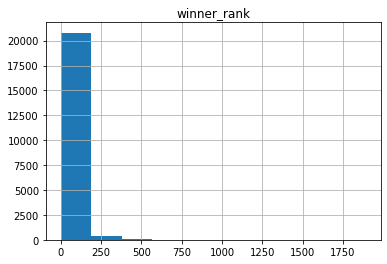

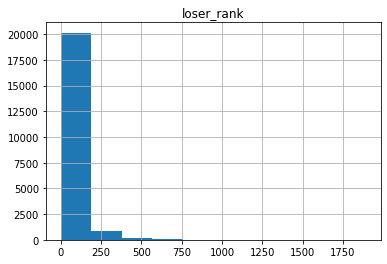

In [109]:
print("resumen rank")
rank_resume_winner.show()
all_atp_games_df.hist(column = "winner_rank")
rank_resume_loser.show()
all_atp_games_df.hist(column = "loser_rank")

El ranking de los jugadores no es normal, pero esto es normal ya que estamos trabajando con todas las partidas, y dado que el rango que necesitan los jugadores para participar en estos tipos de torneos es alto, obviamente en la mayor parte de los partidos están todos agrupados en los primeros 200 del ATP.

resumen game lenght
+-----------------+------+----+-----+-----------------+------------------+
|             mean|median|  Q1|   Q3|         kurtosis|          skewness|
+-----------------+------+----+-----+-----------------+------------------+
|108.3782495000769| 101.0|78.0|131.0|47.24778475384841|2.7979187477453453|
+-----------------+------+----+-----+-----------------+------------------+



array([[<AxesSubplot:title={'center':'minutes'}>]], dtype=object)

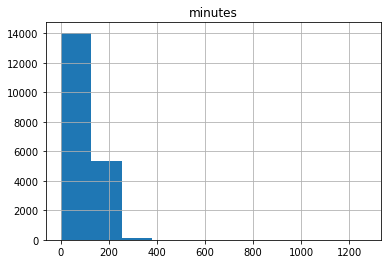

In [110]:
print("resumen game lenght")
minute_resume.show()
all_atp_games_df.hist(column = "minutes")

Observando la duración de las partidas, podemos observar que suelen durar una hora y 40 minutos de media, 

In [111]:
print("resumen game lenght by surface")
minute_resume_by_surface.show()

resumen game lenght by surface
+-------+------------------+------+-----+-----+-----------------+------------------+-----+
|surface|              mean|median|   Q1|   Q3|         kurtosis|          skewness|count|
+-------+------------------+------+-----+-----+-----------------+------------------+-----+
| Carpet|             137.0| 137.0|137.0|137.0|              NaN|               NaN|    1|
|   Clay|108.83699573630699| 101.0| 79.0|132.0|88.14447246734528| 4.050356683093371| 6098|
|   Hard|107.20617547606335|  99.0| 78.0|129.0|34.39829821560615| 2.361124034094892|11238|
|  Grass|113.15466297322253| 105.0| 79.0|138.0|10.15004571698581|1.7155598020131566| 2166|
+-------+------------------+------+-----+-----+-----------------+------------------+-----+



Al observar la duración de las partidas por el tipo de pista, podemos ver que la pista de alfombra tiene una duración más alta de media, esto podemos ver que se debe a que únicamente tenemos 1 registro de este tipo de pista.
Por otro lado se observa que en cesped la media es ligeramente superior, lo cual puede deberse a que cesped es el tipo de cancha más rápido, lo que pueda ayudar a que los jugadores puedan aguantar más en cada punto y esto haga que dure más la partida.

In [148]:
hand_resume_winner_surface = all_atp_games.groupBy('winner_hand').agg(count('surface').alias('count'), (count('surface')/all_atp_games.count()).alias('percentage'))
hand_resume_loser_surface = all_atp_games.groupBy('loser_hand').agg(count('surface').alias('count'), (count('surface')/all_atp_games.count()).alias('percentage'))

hand_resume_winner_surface.show()
hand_resume_loser_surface.show()


all_atp_games.crosstab('tourney_level','winner_hand').orderBy('tourney_level_winner_hand', ascending=True).show(n=50)

all_atp_games.filter("winner_rank < 50").crosstab('winner_rank','winner_hand').orderBy('winner_rank_winner_hand', ascending=True).show(n=50)


+-----------+-----+-------------------+
|winner_hand|count|         percentage|
+-----------+-----+-------------------+
|          L| 2812|0.13170343309446864|
|          R|18539| 0.8682965669055314|
+-----------+-----+-------------------+

+----------+-----+-------------------+
|loser_hand|count|         percentage|
+----------+-----+-------------------+
|         L| 2929|0.13718327010444475|
|         R|18422| 0.8628167298955552|
+----------+-----+-------------------+

+-------------------------+----+-----+
|tourney_level_winner_hand|   L|    R|
+-------------------------+----+-----+
|                        A|1565|10079|
|                        D|  87|  711|
|                        F|  12|  133|
|                        G| 509| 3557|
|                        M| 639| 4059|
+-------------------------+----+-----+

+-----------------------+---+---+
|winner_rank_winner_hand|  L|  R|
+-----------------------+---+---+
|                    1.0|188|417|
|                   10.0| 17|311|
| 

Podemos observar que la dominancia de la mano derecha es constante en todos los niveles de juego y todos los jugadores que han tenido cierto rango en el ranking ATP, lo que es entendible ya que generalmente la gente suele ser diestra.

### Entrenamiento y evaluación de modelo

En la tarea de clasificación, teniendo en cuenta las siguientes variables de los jugadores (a la hora de introducir los datos habrá que predefinir dos jugadores, uno como ganador y otro como perdedor):
- hand: mano dominante
- tourney_level: Nivel de la competición donde se juega el partido
- ht: altura
- age: edad
- rank: posición en el ranking ATP
- rank_points: puntos en el ranking ATP

Trataremos de predecir que tipo de superficie sería la más idonea para que el jugador introducido como vencedor obtenga la victoria:
- surface: tipo de pista


+-------+-------------+------------+-----------+---------+-------------+----------+--------+-------------+-----------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|surface|tourney_level|tourney_date|winner_hand|winner_ht|   winner_age|loser_hand|loser_ht|    loser_age|      score|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+-------+-------------+------------+-----------+---------+-------------+----------+--------+-------------+-----------+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|   Har

In [13]:
all_atp_games

DataFrame[tourney_id: string, tourney_name: string, surface: string, tourney_level: string, tourney_date: int, winner_hand: string, winner_ht: double, winner_age: double, loser_hand: string, loser_ht: double, loser_age: double, score: string, minutes: double, w_ace: double, w_df: double, w_svpt: double, w_1stIn: double, w_1stWon: double, w_2ndWon: double, w_SvGms: double, w_bpSaved: double, w_bpFaced: double, l_ace: double, l_df: double, l_svpt: double, l_1stIn: double, l_1stWon: double, l_2ndWon: double, l_SvGms: double, l_bpSaved: double, l_bpFaced: double, winner_rank: double, winner_rank_points: double, loser_rank: double, loser_rank_points: double]